### Using tensor flow to fit a straight line

We now (mis-)use tensorflow to create something simple as fitting a straight line.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Creating some data

In [2]:
N = 30
x_data = (np.linspace(0,10,N)).astype('float32')
y_data = (2.42 * x_data + 0.42 + np.random.normal(0,1,N)).astype('float32')

(30,)

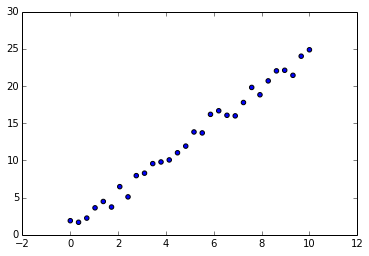

In [3]:
plt.scatter(x_data,y_data)
np.shape(x_data)

### Building the TensorFlow Graph

We are now defining the model for TensorFlow, for finding the optimal values we need to minimize the residual sum of squares: The sum of the quadratic deviation of the data $y_i$ to the model $\hat{y}_i = a \cdot x_i + b$ for all $N$ data points $i$

$$
    \sum_{i=1}^N(y_i - a*x_i+b)^2
$$

As a first step we write a TensorFlow-graph, with which we can calculate this residual sum. What do we need?

* 2 variables (a,b) `tf.Variable` with the start values e.g. 1.0, 0.01
* 2 data vectors, or in TensorFlow parlance one dimensional tensors in which we can feed the data

You might ask, why we do the differentiation between variables and place_holders. Variables reflect the parameters of state of the model, while placeholders the data we feed in. Later, for more complex models, we won't feed in all data at once but random batches (minibatches) of the complete data.

In [4]:
# Defining the graph (construction phase)
a = tf.Variable(1.0, name = 'a') #Note that 1.0 is needed
b = tf.Variable(0.01, name = 'b')
x = tf.placeholder('float32', [N], name='x_data')
y = tf.placeholder('float32', [N], name='y_data')
loss = tf.reduce_sum(tf.square(a*x + b - y)) #Sum is called reduce_sum 

init_op = tf.initialize_all_variables() #Initialization ('symbolic')

# Working with a concrete realization (launching a graph). 
# A session sess is created  with the with construct 
# the session is closed, when moving out of the with class
with tf.Session() as sess: 
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    res = sess.run(loss, feed_dict={x:x_data, y:y_data, a:3.0, b:0.42})
    print("Loss {} (a=3.0, b=0.42)".format(res))

Loss 344.514953613 (a=3.0, b=0.42)


### Optimizing the variables a and b

We now let TensorFlow find the optimal (lowest loss) values of a, b. We do this with a `GradientDescentOptimizer`, which does a steepest descent with a given learning rate. The opimizes is given the loss to minimize and it builds the necessary gradients (using at the graph) for doing the gradient descent itself.

In [5]:
train_op = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)
# Other optimizers 
#train_op = tf.train.AdamOptimizer().minimize(loss) 
#train_op = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(loss)

epochs = 200
results = np.zeros((epochs, 4))
init_op = tf.initialize_all_variables() #Initialization
with tf.Session() as sess:
    sess.run(init_op) #Running the initialization
    for e in range(epochs): #Fitting the data for some epochs
        res = sess.run([train_op, loss, a, b], feed_dict={x:x_data, y:y_data})  
        results[e] = res
        if ((e < 5) | (e > epochs-5)):
            print("Epoch{} Loss {} (a={}, b={})".format(e,res[1],res[2],res[3]))
    res = sess.run([loss, a, b], feed_dict={x:x_data, y:y_data})

Epoch0 Loss 2296.54980469 (a=1.30410981178, b=0.056304179132)
Epoch1 Loss 1448.64746094 (a=1.54495990276, b=0.0932072401047)
Epoch2 Loss 916.657714844 (a=1.73570239544, b=0.122663378716)
Epoch3 Loss 582.875671387 (a=1.88675498962, b=0.146220505238)
Epoch4 Loss 373.451965332 (a=2.00636935234, b=0.165104717016)
Epoch196 Loss 19.0639801025 (a=2.43587446213, b=0.413452327251)
Epoch197 Loss 19.0573062897 (a=2.43575453758, b=0.414259552956)
Epoch198 Loss 19.0506477356 (a=2.43563485146, b=0.415065526962)
Epoch199 Loss 19.0440216064 (a=2.43551516533, b=0.415870279074)


### Inspection of the results
Learning curve and fit.

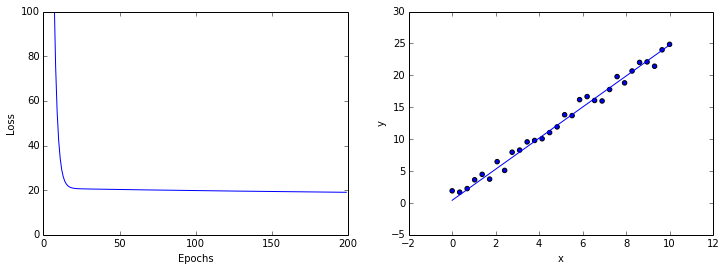

In [6]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.plot(results[0:200,1])
plt.ylim([0,100])
plt.xlabel("Epochs")
plt.ylabel("Loss")

fig.add_subplot(122)
ablineValues = np.zeros_like(x_data)
for i,x_val in enumerate(x_data):
  ablineValues[i] = res[1]*x_val+res[2]
plt.scatter(x_data,y_data)
plt.plot(x_data, ablineValues)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

What is the correct value for the fit?

In [7]:
np.polyfit(x_data,y_data,1), res

(array([ 2.3581152 ,  0.93678743], dtype=float32),
 [19.037403, 2.4355152, 0.41587028])

Out procedure has not excatly found the optimum, but that's usually not a problem for neural networks, since we do not need to find the global minimum for a good model. Note that TensorFlow currently does not support advanced optimization methods like 'L-BFGS' yet see http://ktsiegel.com/6869.pdf